In [2]:
%load_ext autoreload
%autoreload 2

import pyqg_subgrid_experiments as pse
from pyqg_generative.models.cgan_regression import CGANRegression
from pyqg_generative.models.ols_model import OLSModel
from pyqg_generative.models.cvae_regression import CVAERegression
from pyqg_generative.tools.cnn_tools import apply_function
from pyqg_generative.tools.parameters import EDDY_PARAMS
from pyqg_generative.tools.operators import Operator1, PV_subgrid_forcing
from pyqg_generative.tools.plot_helpers import *
from pyqg_generative.tools.comparison_tools import dataset_smart_read
from pyqg_generative.tools.operators import Operator1, Operator2, PV_subgrid_forcing, ave_lev, coord
import os
import matplotlib.pyplot as plt
import torch
import xarray as xr
import numpy as np
import pyqg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import torch
torch.cuda.is_available()

False

In [4]:
ds = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator1-48/0.nc')

In [5]:
idx = dict(time=-1)

In [6]:
m = pyqg.QGModel(nx=48, tmax=0)
m.q = ds.q.isel(idx).astype('float64').values

INFO:  Logger initialized


In [126]:
mse = OLSModel(folder='/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/OLSModel-0/model/')
gan = CGANRegression(nx=48, regression='None', folder='/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/CGANRegression-retrain-0/model')
vae = CVAERegression(regression='None', folder='/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/CVAERegression-None-0/model')

reading OLSModel from /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/OLSModel-0/model/
reading CGANRegression G, D from /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/CGANRegression-retrain-0/model
reading CVAERegression from /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/CVAERegression-None-0/model


# CPU 12 cores. Scaling linear

In [25]:
%%time
dq_gan = gan.predict_mean_snapshot(m, M=100)

CPU times: user 52.3 s, sys: 1.16 s, total: 53.4 s
Wall time: 4.71 s


In [36]:
%%time
dq_vae = vae.predict_mean_snapshot(m, M=100)

CPU times: user 50.7 s, sys: 1.07 s, total: 51.8 s
Wall time: 4.55 s


In [14]:
%%time
gan.predict_mean_snapshot(m, M=10).shape

CPU times: user 707 ms, sys: 248 ms, total: 955 ms
Wall time: 88.4 ms


(2, 48, 48)

In [15]:
%%time
gan.predict_mean_snapshot(m, M=1).shape

CPU times: user 123 ms, sys: 67.2 ms, total: 190 ms
Wall time: 18.7 ms


(2, 48, 48)

# GPU AMD
M=1; 3.4 ms
M=10; 5.1 ms
M=100; 30 ms

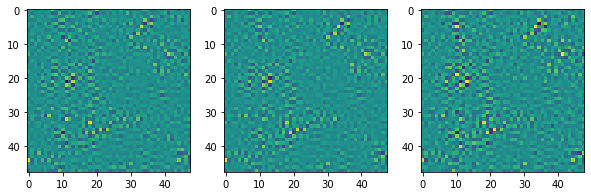

In [50]:
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.imshow(dq_gan[0], vmin=-4e-11, vmax=4e-11)
plt.subplot(1,3,2)
plt.imshow(dq_vae[0], vmin=-4e-11, vmax=4e-11)
plt.subplot(1,3,3)
plt.imshow(ds.q_forcing_advection.isel(lev=0,**idx), vmin=-4e-11, vmax=4e-11)

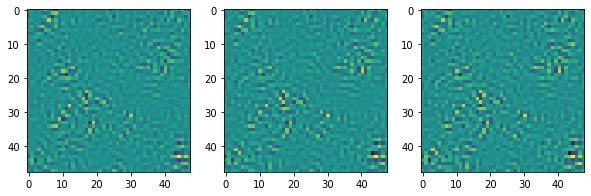

In [48]:
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.imshow(dq_gan[1], vmin=-1e-12, vmax=1e-12)
plt.subplot(1,3,2)
plt.imshow(dq_vae[1], vmin=-1e-12, vmax=1e-12)
plt.subplot(1,3,3)
plt.imshow(ds.q_forcing_advection.isel(lev=1,**idx), vmin=-1e-12, vmax=1e-12)

# Residuals Autocorrelation function

In [262]:
ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/[0-9].nc', concat_dim='run', combine='nested').isel(time=-1)


In [263]:
m = pyqg.QGModel(**EDDY_PARAMS.nx(256)._update(dict(tmax=3600*2000)))
m.q = ds.q.isel(run=0).values.astype('float64')

INFO:  Logger initialized


In [264]:
forcings = []
forcings_predict = []
qs = []

In [265]:
while(1<2):
    forcing, mf = PV_subgrid_forcing(m.q, 48, Operator1, EDDY_PARAMS)
    forcing_predict = mse.predict_snapshot(mf,None)
    
    forcings.append(forcing)
    forcings_predict.append(forcing_predict)
    qs.append(mf.q)
    m._step_forward()
    if m.t > m.tmax:
        break

In [266]:
ds = xr.Dataset()
ds['dq'] = xr.DataArray(forcings, dims=['time', 'lev', 'x', 'y'])
ds['dq_pred'] = xr.DataArray(forcings_predict, dims=['time', 'lev', 'x', 'y'])
ds['q'] = xr.DataArray(qs, dims=['time', 'lev', 'x', 'y'])
ds['residual'] = ds['dq'] - ds['dq_pred']

In [267]:
def autocorr(array):
    nt = len(array.time)
    out = np.zeros((nt,2))
    for n in range(nt):
        out[n,:] = xr.corr(array.isel(time=0), array.isel(time=n), dim=('x','y'))
    out = xr.DataArray(out, dims=('lag', 'lev'))
    out['lag'] = out['lag'] / 24
    return out

In [268]:
acf_residual = autocorr(ds['residual'])
acf_forcing = autocorr(ds['dq'])
acf_q = autocorr(ds['q'])

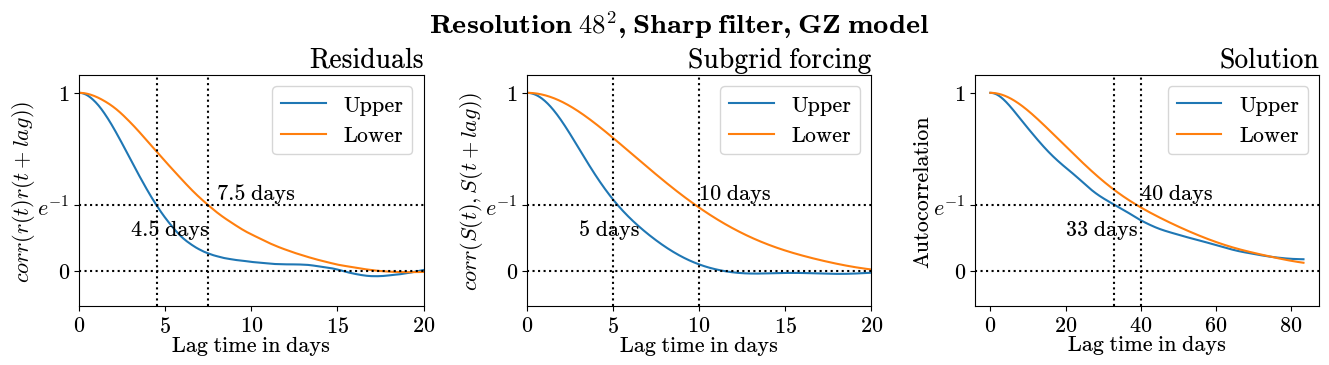

In [340]:
default_rcParams({'font.size': 16,
        'axes.labelsize': 16,
        'axes.titlesize': 20,
        'xtick.labelsize': 16,
        'ytick.labelsize': 16,
        'legend.fontsize': 16})
plt.figure(figsize=(16,3))
plt.subplot(1,3,1)
acf_residual.plot.line(x='lag')
plt.xlabel('Lag time in days')
plt.ylabel('$corr(r(t)r(t+lag))$')
plt.title('Residuals')
plt.xlim([0,20])
plt.ylim([-0.2,1.1])
plt.axhline(y=np.exp(-1), ls=':', color='k')
plt.axhline(y=0, ls=':', color='k')
plt.text(3,0.2,'4.5 days')
plt.text(8,0.4,'7.5 days')
plt.axvline(x=4.5, ls=':', color='k')
plt.axvline(x=7.5, ls=':', color='k')
plt.legend(('Upper', 'Lower'))
plt.yticks([0,np.exp(-1),1],['0','$e^{-1}$','1'])
plt.subplot(1,3,2)
acf_forcing.plot.line(x='lag')
plt.xlabel('Lag time in days')
plt.ylabel('$corr(S(t),S(t+lag))$')
plt.title('Subgrid forcing')
plt.xlim([0,20])
plt.ylim([-0.2,1.1])
plt.axvline(x=5, ls=':', color='k')
plt.axvline(x=10, ls=':', color='k')
plt.text(3,0.2,'5 days')
plt.text(10,0.4,'10 days')
plt.axhline(y=np.exp(-1), ls=':', color='k')
plt.axhline(y=0, ls=':', color='k')
plt.legend(('Upper', 'Lower'))
plt.yticks([0,np.exp(-1),1],['0','$e^{-1}$','1'])
plt.subplot(1,3,3)
acf_q.plot.line(x='lag')
plt.xlabel('Lag time in days')
plt.ylabel('Autocorrelation')
plt.title('Solution')
plt.ylim([-0.2,1.1])
plt.axvline(x=33, ls=':', color='k')
plt.axvline(x=40, ls=':', color='k')
plt.text(20,0.2,'33 days')
plt.text(40,0.4,'40 days')
plt.axhline(y=np.exp(-1), ls=':', color='k')
plt.axhline(y=0, ls=':', color='k')
plt.legend(('Upper', 'Lower'))
plt.yticks([0,np.exp(-1),1],['0','$e^{-1}$','1'])
plt.suptitle('Resolution $48^2$, Sharp filter, GZ model', y=1.10, fontweight='bold')
plt.savefig('paper_figures_1/a_priori_time_correlation.pdf')

# Online simulations with deterministic part

In [360]:
gz_mean_4 = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/OLSModel-0/eddy-constant-0/[0-9].nc').isel(time=slice(None,None,4))
gz_mean_2 = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/OLSModel-0/eddy-7200-constant-0/[0-9].nc').isel(time=slice(None,None,4))

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/OLSModel-0/eddy-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/OLSModel-0/eddy-7200-constant-0/[0-9].nc


In [361]:
gz_4 = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/MeanVarModel-0/eddy-constant-0/[0-9].nc').isel(time=slice(None,None,4))
gz_2 = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/MeanVarModel-0/eddy-7200-constant-0/[0-9].nc').isel(time=slice(None,None,4))



/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/MeanVarModel-0/eddy-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/MeanVarModel-0/eddy-7200-constant-0/[0-9].nc


In [362]:
gan_4 = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/CGANRegression-retrain-0/eddy-constant-0/[0-9].nc').isel(time=slice(None,None,4))
gan_2 = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/CGANRegression-retrain-0/eddy-7200-constant-0/[0-9].nc').isel(time=slice(None,None,4))


/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/CGANRegression-retrain-0/eddy-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/CGANRegression-retrain-0/eddy-7200-constant-0/[0-9].nc


In [363]:
gan_mean_4 = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/CGANRegression-retrain-0/eddy-deterministic/[0-9].nc').isel(time=slice(None,None,4))
gan_mean_2 = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/CGANRegression-retrain-0/eddy-7200-deterministic/[0-9].nc').isel(time=slice(None,None,4))


/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/CGANRegression-retrain-0/eddy-deterministic/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/CGANRegression-retrain-0/eddy-7200-deterministic/[0-9].nc


In [364]:
vae_4 = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/CVAERegression-None-0/eddy-constant-0/[0-9].nc').isel(time=slice(None,None,4))
vae_2 = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/CVAERegression-None-0/eddy-7200-constant-0/[0-9].nc').isel(time=slice(None,None,4))


/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/CVAERegression-None-0/eddy-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/CVAERegression-None-0/eddy-7200-constant-0/[0-9].nc


In [365]:
vae_mean_4 = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/CVAERegression-None-0/eddy-deterministic/[0-9].nc').isel(time=slice(None,None,4))
vae_mean_2 = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/CVAERegression-None-0/eddy-7200-deterministic/[0-9].nc').isel(time=slice(None,None,4))


/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/CVAERegression-None-0/eddy-deterministic/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/CVAERegression-None-0/eddy-7200-deterministic/[0-9].nc


In [366]:
target = dataset_smart_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-48.nc').isel(time=slice(None,None,4))
coarse = dataset_smart_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_48/[0-9].nc').isel(time=slice(None,None,4))

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-48.nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_48/[0-9].nc


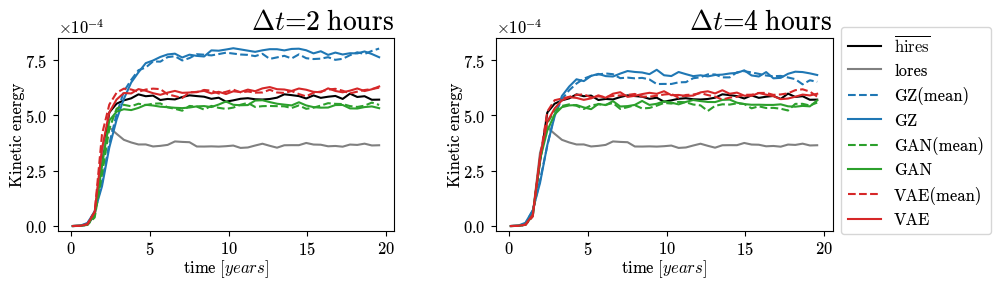

In [396]:
default_rcParams({'font.size': 12,
        'axes.labelsize': 12,
        'axes.titlesize': 20,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12})
color = ['tab:blue', 'tab:blue', 'tab:green', 'tab:green', 'tab:red', 'tab:red']
ls = ['--', '-', '--', '-', '--', '-']
label = ['GZ(mean)', 'GZ', 'GAN(mean)', 'GAN', 'VAE(mean)', 'VAE']

plt.figure(figsize=(10,2.5))
plt.subplot(1,2,1)
target.KE_time.plot(color='k', label='$\overline{\mathrm{hires}}$')
coarse.KE_time.plot(color='gray', label='lores')
for j, model in enumerate([gz_mean_2, gz_2, gan_mean_2, gan_2, vae_mean_2, vae_2]):
    model.KE_time.plot(color=color[j], ls=ls[j], label=label[j])
plt.ylabel('Kinetic energy')
plt.title('$\Delta t$=2 hours')
plt.ylim([-0.2e-4, 8.5e-4])
plt.yticks([0,2.5e-4,5e-4,7.5e-4])
plt.subplot(1,2,2)
target.KE_time.plot(color='k', label='$\overline{\mathrm{hires}}$')
coarse.KE_time.plot(color='gray', label='lores')
for j, model in enumerate([gz_mean_4, gz_4, gan_mean_4, gan_4, vae_mean_4, vae_4]):
    model.KE_time.plot(color=color[j], ls=ls[j], label=label[j])
plt.ylabel('Kinetic energy')
plt.title('$\Delta t$=4 hours')
plt.ylim([-0.2e-4, 8.5e-4])
plt.yticks([0,2.5e-4,5e-4,7.5e-4])
plt.legend(ncol=1, bbox_to_anchor=(1,1.1))
plt.savefig('paper_figures_1/deterministic_models.pdf')

# Is there difference in metrics between stochastic and deterministic models?

In [18]:
import json
import glob
from pyqg_generative.tools.comparison_tools import dataset_smart_read, distrib_score, spectral_score, plot_PDFs, plot_panel_figure

distance = {}
i = 0
for file in glob.glob('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/difference_recompute/output/*.json'):
    i += 1
    print(i, file)
    with open(file, 'r') as f:
        d = json.load(f)
        key = d.pop('key')
        distance[key] = d

1 /scratch/pp2681/pyqg_generative/Reference-Default-scaled/difference_recompute/output/Operator1-64-CGANRegression-4-eddy-constant-0.json
2 /scratch/pp2681/pyqg_generative/Reference-Default-scaled/difference_recompute/output/Operator2-48-CGANRegression-3-eddy-3600-constant-0.json
3 /scratch/pp2681/pyqg_generative/Reference-Default-scaled/difference_recompute/output/Operator2-48-ZannaBolton-0-eddy-constant-0.json
4 /scratch/pp2681/pyqg_generative/Reference-Default-scaled/difference_recompute/output/Operator2-48-Reference-eddy-28800.json
5 /scratch/pp2681/pyqg_generative/Reference-Default-scaled/difference_recompute/output/Operator2-96-CGANRegression-4-eddy-constant-0.json
6 /scratch/pp2681/pyqg_generative/Reference-Default-scaled/difference_recompute/output/Operator1-96-OLSModel-0-jet-constant-0.json
7 /scratch/pp2681/pyqg_generative/Reference-Default-scaled/difference_recompute/output/Operator2-48-CVAERegression-None-0-jet_40years-constant-0.json
8 /scratch/pp2681/pyqg_generative/Refer

In [17]:
distrib_score(distance['Operator1-48/CGANRegression-retrain-0/eddy-7200-deterministic'])

{'distrib_diff_q1': 0.024183838367351915,
 'distrib_diff_q2': 0.0854550945676209,
 'distrib_diff_u1': 0.019475327266984845,
 'distrib_diff_u2': 0.05865269489711223,
 'distrib_diff_v1': 0.01976011664320822,
 'distrib_diff_v2': 0.05148004679754478,
 'distrib_diff_KE1': 0.039576762966347816,
 'distrib_diff_KE2': 0.0891848740291501,
 'distrib_diff_Ens1': 0.047193048173474764,
 'distrib_diff_Ens2': 0.021377345274713883,
 'spectral_diff_KEspec1': 0.2190592596663153,
 'spectral_diff_KEspec2': 0.19525739139253065,
 'spectral_diff_Eflux': 0.3672326845868827,
 'spectral_diff_APEgenspec': 0.19649285460186572}

In [32]:
print(distrib_score(distance['Operator1-48/CGANRegression-retrain-0/eddy-constant-0']))
print(spectral_score(distance['Operator1-48/CGANRegression-retrain-0/eddy-constant-0']))
print(distrib_score(distance['Operator1-48/CGANRegression-retrain-0/eddy-7200-constant-0']))
print(spectral_score(distance['Operator1-48/CGANRegression-retrain-0/eddy-7200-constant-0']))

0.030772943913676937
0.1637214035224197
0.044208316684002366
0.2478591601373818


# What is wrong with models having long time correlation?

In [36]:
READ_CACHE=True
EXP = 'eddy-constant-48'
REF = 'reference_48'
OPERATOR = 'Operator1'
RESOLUTION=48
DELTA = 0.25

In [37]:
def read_experiment(model='OLSModel', model_num=0, resolution=64, operator='Operator1', exp=EXP, read_cache=READ_CACHE, delta=DELTA):
    folder = os.path.join('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain', operator+'-'+str(resolution),model+'-'+str(model_num),exp)
    path = os.path.join(folder,'[0-9].nc')

    keyphrase = 'Warning: CFL>1. Computations are stopped.'
    err = os.path.join(folder, '*err*')
    os.system(f'cat {err} | grep "{keyphrase}"')
    
    ds = dataset_smart_read(path, read_cache=read_cache, delta=delta)
    return ds.isel(time=slice(0,None,2))

In [38]:
def collapse_trials(**kw):
    ds = []
    for j in range(5):
        if kw['resolution']==48 and kw['operator'] == 'Operator1' and kw['model'] in ['OLSModel', 'MeanVarModel', 'CGANRegression'] and j==3:
            continue
        if kw['resolution']==64 and kw['operator'] == 'Operator1' and kw['model'] in ['CVAERegression-None'] and j in [2,3]:
            continue
        if kw['resolution']==96 and kw['operator'] == 'Operator1' and kw['model'] in ['CVAERegression-None'] and j in [4]:
            continue
        ds.append(read_experiment(model_num=j, **kw))
    ds = xr.concat(ds, dim='trial')
    
    return ds

In [39]:
%%time
#mse = collapse_trials(resolution=RESOLUTION, operator=OPERATOR, model='OLSModel')

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.2 µs


In [40]:
#gz = collapse_trials(resolution=RESOLUTION, operator=OPERATOR, model='MeanVarModel')
gan = collapse_trials(resolution=RESOLUTION, operator=OPERATOR, model='CGANRegression-retrain')
vae = collapse_trials(resolution=RESOLUTION, operator=OPERATOR, model='CVAERegression-None')

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/CGANRegression-retrain-0/eddy-constant-48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/CGANRegression-retrain-1/eddy-constant-48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/CGANRegression-retrain-2/eddy-constant-48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/CGANRegression-retrain-3/eddy-constant-48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/CGANRegression-retrain-4/eddy-constant-48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/CVAERegression-None-0/eddy-constant-48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/CVAERegression-None-1/eddy-constant-48/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scal

In [18]:
#hires = dataset_smart_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/[0-9].nc', delta=DELTA, read_cache=READ_CACHE).isel(time=slice(0,None,2))
target = dataset_smart_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/{OPERATOR}-{str(RESOLUTION)}.nc', delta=DELTA, read_cache=READ_CACHE).isel(time=slice(0,None,2))
coarse = dataset_smart_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/{REF}/[0-9].nc', delta=DELTA, read_cache=READ_CACHE).isel(time=slice(0,None,2))
#coarse64 = dataset_smart_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_64/[0-9].nc', delta=DELTA, read_cache=READ_CACHE).isel(time=slice(0,None,2))

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator1-48.nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_48/[0-9].nc


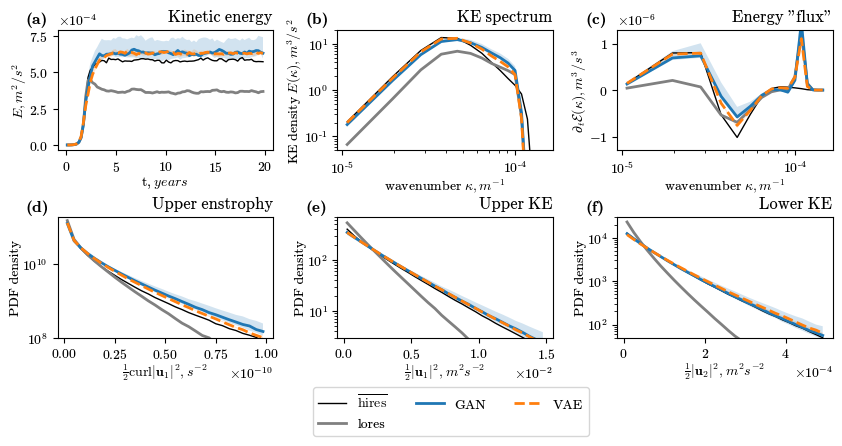

In [41]:
default_rcParams({'lines.linewidth': 2})
fig, axs = plt.subplots(2,3,figsize=(10,4))
plt.subplots_adjust(hspace=0.55)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
lss = ['-', '--', '-.', ':']
lws = [None, None, None, None]
alphas = [0.2, 0.2, 0.2, 0.2]
hatch = [None, None, None, None]
#models = [mse, gz, gan, vae]
#labels=['GZ(mean)', 'GZ', 'GAN', 'VAE']
models = [gan, vae]
labels=['GAN', 'VAE']

ax = axs[0][0]
target.KE_time.plot(ax=ax, color='k', ls='-', lw=1)
coarse.KE_time.plot(ax=ax, color='gray')
for j, m in enumerate(models):
    m.KE_time.median('trial').plot(ax=ax, color=colors[j], ls=lss[j], lw=lws[j])
    ax.fill_between(m.time, m.KE_time.min('trial'), m.KE_time.max('trial'), color=colors[j], alpha=alphas[j], edgecolor=None)
ax.set_ylabel(r'$E, m^2/s^2$')
ax.set_xlabel('t, $years$')
ax.set_title('Kinetic energy')

ax = axs[0][1]
(0.5*target.KEspecr_mean).plot(ax=ax, color='k', ls='-', lw=1)
(0.5*coarse.KEspecr_mean).plot(ax=ax, color='gray')
for j, m in enumerate(models):
    (0.5*m.KEspecr_mean.median('trial')).plot(ax=ax, color=colors[j], ls=lss[j], lw=lws[j])
    ax.fill_between(m.kr, 0.5*m.KEspecr_mean.min('trial'), 0.5*m.KEspecr_mean.max('trial'), color=colors[j], alpha=alphas[j], edgecolor=None)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([5e-2, 2e+1])
ax.set_ylabel('KE density $E(\kappa), m^3/s^2$')
ax.set_xlabel(r'wavenumber $\kappa, m^{-1}$')
ax.set_title('KE spectrum')
    
ax = axs[0][2]
target.Efluxr.plot(ax=ax, color='k', ls='-', lw=1)
coarse.Efluxr.plot(ax=ax, color='gray')
for j, m in enumerate(models):
    m.Efluxr.median('trial').plot(ax=ax, color=colors[j], ls=lss[j], lw=lws[j])
    ax.fill_between(m.kr, m.Efluxr.min('trial'), m.Efluxr.max('trial'), color=colors[j], alpha=alphas[j], edgecolor=None)
ax.set_xscale('log')
ax.set_ylim([-1.3e-6, 1.3e-6])
ax.set_ylabel(r'$\partial_t \mathcal{E}(\kappa), m^3/s^3$')
ax.set_xlabel(r'wavenumber $\kappa, m^{-1}$')
ax.set_title('Energy "flux"')

for col,var in enumerate(['PDF_Ens1', 'PDF_KE1', 'PDF_KE2']):
    ax=axs[1][col]
    target[var].plot(ax=ax, color='k', ls='-', lw=1, label=r'$\overline{\mathrm{hires}}$')
    coarse[var].plot(ax=ax, color='gray', label='lores')
    
    for j, m in enumerate(models):
        m[var].median('trial').plot(ax=ax, color=colors[j], ls=lss[j], lw=lws[j], label=labels[j])
        xx=[k for k in m[var].median('trial').coords.values()][0]
        ax.fill_between(xx, m[var].min('trial'), m[var].max('trial'), color=colors[j], alpha=alphas[j], edgecolor=None)
        ax.set_yscale('log')

ax = axs[1][0]
ax.set_ylabel('PDF density')
ax.set_xlabel(r'$\frac{1}{2}\mathrm{curl}|\mathbf{u}_1|^2, s^{-2}$')
ax.set_title('Upper enstrophy')

ax = axs[1][1]
ax.set_ylabel('PDF density')
ax.set_xlabel(r'$\frac{1}{2}|\mathbf{u}_1|^2, m^2s^{-2}$')
ax.set_title('Upper KE')

ax = axs[1][2]
ax.set_ylabel('PDF density')
ax.set_xlabel(r'$\frac{1}{2}|\mathbf{u}_2|^2, m^2s^{-2}$')
ax.set_title('Lower KE')

if OPERATOR=='Operator1':
    axs[1][0].set_ylim([1e+8, 2e+11])
    axs[1][1].set_ylim([3e+0, 7e+2])
    axs[1][2].set_ylim([5e+1, 3e+4])
else:
    axs[1][0].set_ylim([1e+6, 2e+11])
    axs[1][1].set_ylim([1e-2, 7e+2])
    axs[1][2].set_ylim([5e-1, 3e+4])
    
if False:
    axs[0][1].set_yscale('linear')
    axs[0][1].set_xscale('linear')
    axs[0][1].set_ylim([0, 25])


axs[1][2].legend(bbox_to_anchor=(-0.1,-0.35), ncol=3)

set_letters(x=-0.15)
#fig.suptitle('$48^2$, Gaussian filter', y=1.02, fontweight='bold')
#plt.savefig('paper_figures_1/online_retrain_14400_Gauss.pdf')

In [13]:
gan_0 = collapse_trials(resolution=RESOLUTION, operator=OPERATOR, model='CGANRegression-retrain', exp='eddy-AR1-0')
gan_24 = collapse_trials(resolution=RESOLUTION, operator=OPERATOR, model='CGANRegression-retrain', exp='eddy-AR1-24')
gan_24_constant = collapse_trials(resolution=RESOLUTION, operator=OPERATOR, model='CGANRegression-retrain', exp='eddy-constant-24')

gz_0 = collapse_trials(resolution=RESOLUTION, operator=OPERATOR, model='MeanVarModel', exp='eddy-AR1-0')
gz_12 = collapse_trials(resolution=RESOLUTION, operator=OPERATOR, model='MeanVarModel', exp='eddy-AR1-12')
gz_12_constant = collapse_trials(resolution=RESOLUTION, operator=OPERATOR, model='MeanVarModel', exp='eddy-constant-12')

vae_0 = collapse_trials(resolution=RESOLUTION, operator=OPERATOR, model='CVAERegression-None', exp='eddy-AR1-0')
vae_48 = collapse_trials(resolution=RESOLUTION, operator=OPERATOR, model='CVAERegression-None', exp='eddy-AR1-48')
vae_48_constant = collapse_trials(resolution=RESOLUTION, operator=OPERATOR, model='CVAERegression-None', exp='eddy-constant-48')

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/CGANRegression-retrain-0/eddy-AR1-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/CGANRegression-retrain-1/eddy-AR1-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/CGANRegression-retrain-2/eddy-AR1-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/CGANRegression-retrain-3/eddy-AR1-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/CGANRegression-retrain-4/eddy-AR1-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/CGANRegression-retrain-0/eddy-AR1-24/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/CGANRegression-retrain-1/eddy-AR1-24/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator1-48/CGA

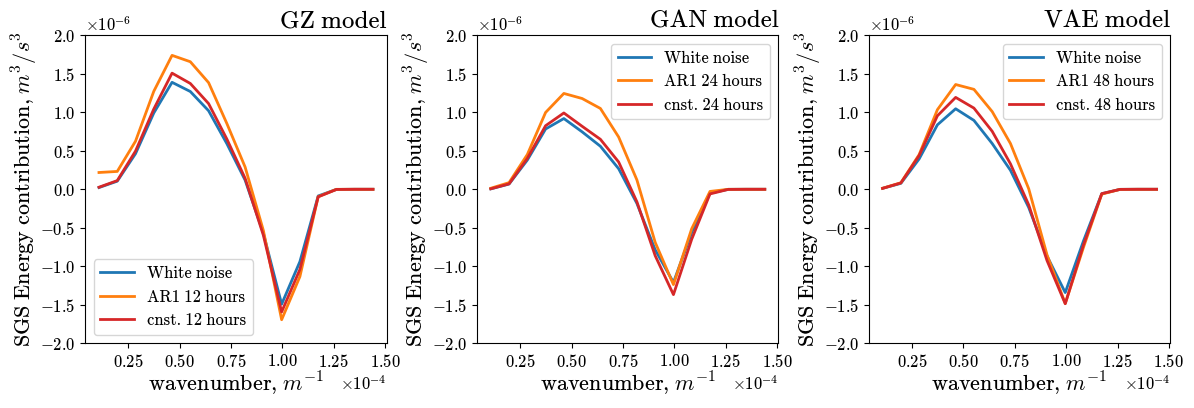

In [15]:
default_rcParams({'lines.linewidth': 2,
                    'font.size': 12,
                    'axes.labelsize': 16,
                    'axes.titlesize': 18,
                    'xtick.labelsize': 12,
                    'ytick.labelsize': 12,
                    'legend.fontsize': 12})
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
gz_0.paramspecr.median('trial').plot(color='tab:blue', label='White noise')
gz_12.paramspecr.median('trial').plot(color='tab:orange', label='AR1 12 hours')
gz_12_constant.paramspecr.median('trial').plot(color='tab:red', label='cnst. 12 hours')
plt.title('GZ model')
plt.legend()
plt.ylim([-2e-6, 2e-6])
plt.ylabel('SGS Energy contribution, $m^3/s^3$')

plt.subplot(1,3,2)
gan_0.paramspecr.median('trial').plot(color='tab:blue', label='White noise')
gan_24.paramspecr.median('trial').plot(color='tab:orange', label='AR1 24 hours')
gan_24_constant.paramspecr.median('trial').plot(color='tab:red', label='cnst. 24 hours')
plt.title('GAN model')
plt.legend()
plt.ylim([-2e-6, 2e-6])
plt.ylabel('SGS Energy contribution, $m^3/s^3$')

plt.subplot(1,3,3)
vae_0.paramspecr.median('trial').plot(color='tab:blue', label='White noise')
vae_48.paramspecr.median('trial').plot(color='tab:orange', label='AR1 48 hours')
vae_48_constant.paramspecr.median('trial').plot(color='tab:red', label='cnst. 48 hours')
plt.title('VAE model')
plt.legend()
plt.ylim([-2e-6, 2e-6])
plt.ylabel('SGS Energy contribution, $m^3/s^3$')
plt.savefig('paper_figures_1/backscatter_tau_response.pdf')

In [43]:
OPERATOR='Operator2'

gan_0 = collapse_trials(resolution=RESOLUTION, operator=OPERATOR, model='CGANRegression-retrain', exp='eddy-constant-0')
gan_24 = collapse_trials(resolution=RESOLUTION, operator=OPERATOR, model='CGANRegression-retrain', exp='eddy-AR1-24')
gan_24_constant = collapse_trials(resolution=RESOLUTION, operator=OPERATOR, model='CGANRegression-retrain', exp='eddy-constant-24')

gz_0 = collapse_trials(resolution=RESOLUTION, operator=OPERATOR, model='MeanVarModel', exp='eddy-constant-0')
gz_24 = collapse_trials(resolution=RESOLUTION, operator=OPERATOR, model='MeanVarModel', exp='eddy-AR1-24')
gz_24_constant = collapse_trials(resolution=RESOLUTION, operator=OPERATOR, model='MeanVarModel', exp='eddy-constant-24')

vae_0 = collapse_trials(resolution=RESOLUTION, operator=OPERATOR, model='CVAERegression-None', exp='eddy-constant-0')
vae_48 = collapse_trials(resolution=RESOLUTION, operator=OPERATOR, model='CVAERegression-None', exp='eddy-AR1-48')
vae_48_constant = collapse_trials(resolution=RESOLUTION, operator=OPERATOR, model='CVAERegression-None', exp='eddy-constant-48')

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator2-48/CGANRegression-retrain-0/eddy-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator2-48/CGANRegression-retrain-1/eddy-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator2-48/CGANRegression-retrain-2/eddy-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator2-48/CGANRegression-retrain-3/eddy-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator2-48/CGANRegression-retrain-4/eddy-constant-0/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator2-48/CGANRegression-retrain-0/eddy-AR1-24/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator2-48/CGANRegression-retrain-1/eddy-AR1-24/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models

In [84]:
vae_60_constant = collapse_trials(resolution=RESOLUTION, operator=OPERATOR, model='CVAERegression-None', exp='eddy-constant-60')

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator2-48/CVAERegression-None-0/eddy-constant-60/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator2-48/CVAERegression-None-1/eddy-constant-60/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator2-48/CVAERegression-None-2/eddy-constant-60/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator2-48/CVAERegression-None-3/eddy-constant-60/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator2-48/CVAERegression-None-4/eddy-constant-60/[0-9].nc


In [63]:
vae_96 = collapse_trials(resolution=RESOLUTION, operator=OPERATOR, model='CVAERegression-None', exp='eddy-AR1-96')

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator2-48/CVAERegression-None-0/eddy-AR1-96/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator2-48/CVAERegression-None-1/eddy-AR1-96/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator2-48/CVAERegression-None-2/eddy-AR1-96/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator2-48/CVAERegression-None-3/eddy-AR1-96/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator2-48/CVAERegression-None-4/eddy-AR1-96/[0-9].nc


In [65]:
vae_384 = collapse_trials(resolution=RESOLUTION, operator=OPERATOR, model='CVAERegression-None', exp='eddy-AR1-384')

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator2-48/CVAERegression-None-0/eddy-AR1-384/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator2-48/CVAERegression-None-1/eddy-AR1-384/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator2-48/CVAERegression-None-2/eddy-AR1-384/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator2-48/CVAERegression-None-3/eddy-AR1-384/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator2-48/CVAERegression-None-4/eddy-AR1-384/[0-9].nc


In [127]:
gan_384 = collapse_trials(resolution=RESOLUTION, operator=OPERATOR, model='CGANRegression-retrain', exp='eddy-AR1-384')

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator2-48/CGANRegression-retrain-0/eddy-AR1-384/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator2-48/CGANRegression-retrain-1/eddy-AR1-384/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator2-48/CGANRegression-retrain-2/eddy-AR1-384/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator2-48/CGANRegression-retrain-3/eddy-AR1-384/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator2-48/CGANRegression-retrain-4/eddy-AR1-384/[0-9].nc


In [89]:
gz_36_constant = collapse_trials(read_cache=False, resolution=RESOLUTION, operator=OPERATOR, model='MeanVarModel', exp='eddy-constant-36')

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator2-48/MeanVarModel-0/eddy-constant-36/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator2-48/MeanVarModel-1/eddy-constant-36/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator2-48/MeanVarModel-2/eddy-constant-36/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator2-48/MeanVarModel-3/eddy-constant-36/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator2-48/MeanVarModel-4/eddy-constant-36/[0-9].nc


In [110]:
gz_384 = collapse_trials(resolution=RESOLUTION, operator=OPERATOR, model='MeanVarModel', exp='eddy-AR1-384')

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator2-48/MeanVarModel-0/eddy-AR1-384/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator2-48/MeanVarModel-1/eddy-AR1-384/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator2-48/MeanVarModel-2/eddy-AR1-384/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator2-48/MeanVarModel-3/eddy-AR1-384/[0-9].nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator2-48/MeanVarModel-4/eddy-AR1-384/[0-9].nc


In [57]:
offline = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator2-48/CGANRegression-retrain-0/offline_test.nc')
offline['Efluxr'] = ave_lev(offline.Eflux, delta=0.25)

Text(0, 0.5, 'SGS Energy contribution, $m^3/s^3$')

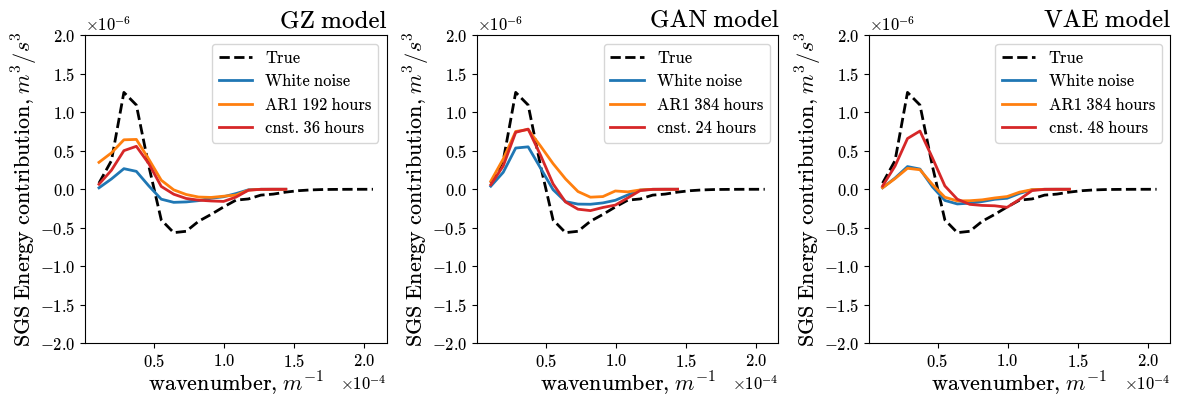

In [130]:
default_rcParams({'lines.linewidth': 2,
                    'font.size': 12,
                    'axes.labelsize': 16,
                    'axes.titlesize': 18,
                    'xtick.labelsize': 12,
                    'ytick.labelsize': 12,
                    'legend.fontsize': 12})
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
offline.Efluxr.plot(color='k', ls='--', label='True')
gz_0.paramspecr.median('trial').plot(color='tab:blue', label='White noise')
gz_192.paramspecr.median('trial').plot(color='tab:orange', label='AR1 192 hours')
gz_36_constant.paramspecr.median('trial').plot(color='tab:red', label='cnst. 36 hours')
plt.title('GZ model')
plt.legend()
plt.ylim([-2e-6, 2e-6])
plt.ylabel('SGS Energy contribution, $m^3/s^3$')

plt.subplot(1,3,2)
offline.Efluxr.plot(color='k', ls='--', label='True')
gan_0.paramspecr.median('trial').plot(color='tab:blue', label='White noise')
gan_384.paramspecr.median('trial').plot(color='tab:orange', label='AR1 384 hours')
gan_24_constant.paramspecr.median('trial').plot(color='tab:red', label='cnst. 24 hours')
plt.title('GAN model')
plt.legend()
plt.ylim([-2e-6, 2e-6])
plt.ylabel('SGS Energy contribution, $m^3/s^3$')

plt.subplot(1,3,3)
offline.Efluxr.plot(color='k', ls='--', label='True')
vae_0.paramspecr.median('trial').plot(color='tab:blue', label='White noise')
vae_384.paramspecr.median('trial').plot(color='tab:orange', label='AR1 384 hours')
vae_48_constant.paramspecr.median('trial').plot(color='tab:red', label='cnst. 48 hours')
plt.title('VAE model')
plt.legend()
plt.ylim([-2e-6, 2e-6])
plt.ylabel('SGS Energy contribution, $m^3/s^3$')
#plt.savefig('paper_figures_1/backscatter_tau_response.pdf')

In [95]:
target = dataset_smart_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/{OPERATOR}-{str(RESOLUTION)}.nc', delta=DELTA, read_cache=READ_CACHE).isel(time=slice(0,None,2))
coarse = dataset_smart_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/{REF}/[0-9].nc', delta=DELTA, read_cache=READ_CACHE).isel(time=slice(0,None,2))

/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/Operator2-48.nc
/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_48/[0-9].nc


Text(1.0, 1.0, 'GZ')

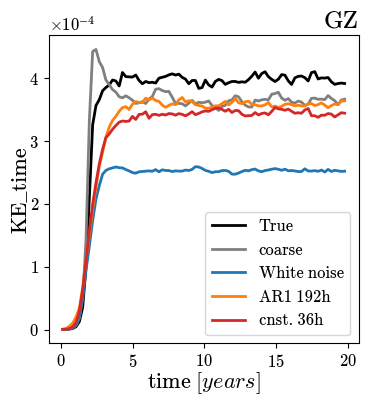

In [146]:
target.KE_time.plot(color='k', label='True')
coarse.KE_time.plot(color='gray', label='coarse')
gz_0.KE_time.median('trial').plot(label='White noise')
gz_192.KE_time.median('trial').plot(label='AR1 192h', color='tab:orange')
gz_36_constant.KE_time.median('trial').plot(label='cnst. 36h', color='tab:red')
plt.legend()
plt.title('GZ')

Text(1.0, 1.0, 'GAN')

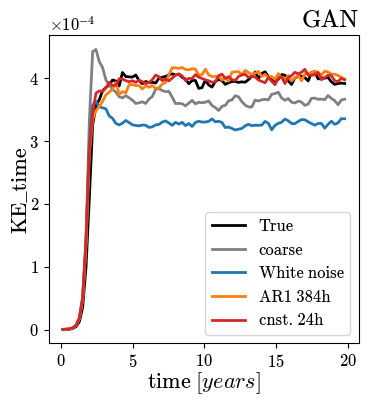

In [147]:
target.KE_time.plot(color='k', label='True')
coarse.KE_time.plot(color='gray', label='coarse')
gan_0.KE_time.median('trial').plot(label='White noise')
gan_384.KE_time.median('trial').plot(label='AR1 384h', color='tab:orange')
gan_24_constant.KE_time.median('trial').plot(label='cnst. 24h', color='tab:red')
plt.legend()
plt.title('GAN')

Text(1.0, 1.0, 'VAE')

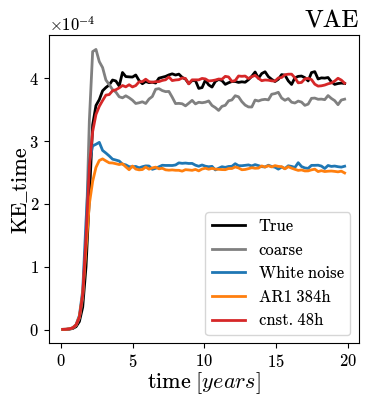

In [148]:
target.KE_time.plot(color='k', label='True')
coarse.KE_time.plot(color='gray', label='coarse')
vae_0.KE_time.median('trial').plot(label='White noise')
vae_384.KE_time.median('trial').plot(label='AR1 384h', color='tab:orange')
vae_48_constant.KE_time.median('trial').plot(label='cnst. 48h', color='tab:red')
plt.legend()
plt.title('VAE')

Text(1.0, 1.0, 'GZ')

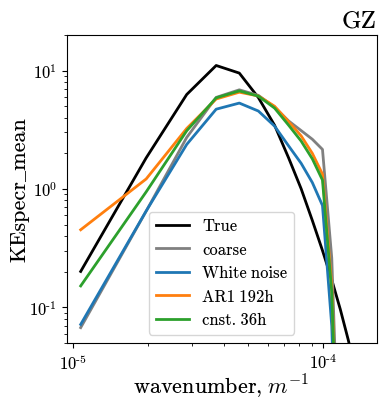

In [167]:
(0.5*target.KEspecr_mean).plot(label='True', color='k')
(0.5*coarse.KEspecr_mean).plot(label='coarse', color='gray')
(0.5*gz_0.KEspecr_mean.median('trial')).plot(label='White noise')
(0.5*gz_192.KEspecr_mean.median('trial')).plot(label='AR1 192h')
(0.5*gz_36_constant.KEspecr_mean.median('trial')).plot(label='cnst. 36h')


plt.yscale('log')
plt.xscale('log')
plt.ylim([5e-2,20])
plt.legend()
plt.title('GZ')

Text(1.0, 1.0, 'GAN')

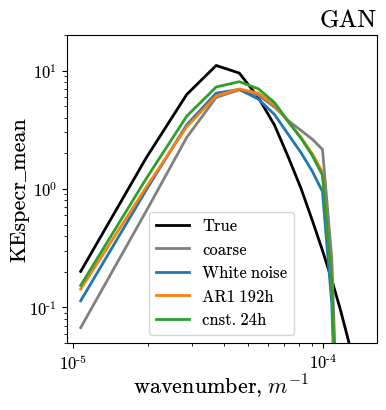

In [171]:
(0.5*target.KEspecr_mean).plot(label='True', color='k')
(0.5*coarse.KEspecr_mean).plot(label='coarse', color='gray')
(0.5*gan_0.KEspecr_mean.median('trial')).plot(label='White noise')
(0.5*gan_192.KEspecr_mean.median('trial')).plot(label='AR1 192h')
(0.5*gan_24_constant.KEspecr_mean.median('trial')).plot(label='cnst. 24h')


plt.yscale('log')
plt.xscale('log')
plt.ylim([5e-2,20])
plt.legend()
plt.title('GAN')

Text(1.0, 1.0, 'VAE')

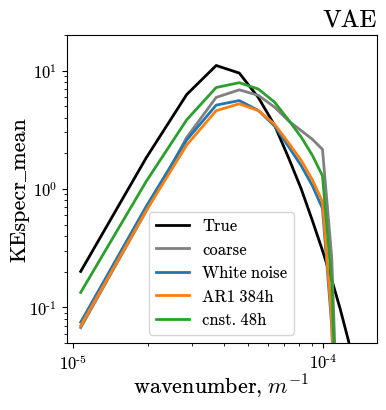

In [175]:
(0.5*target.KEspecr_mean).plot(label='True', color='k')
(0.5*coarse.KEspecr_mean).plot(label='coarse', color='gray')
(0.5*vae_0.KEspecr_mean.median('trial')).plot(label='White noise')
(0.5*vae_384.KEspecr_mean.median('trial')).plot(label='AR1 384h')
(0.5*vae_48_constant.KEspecr_mean.median('trial')).plot(label='cnst. 48h')


plt.yscale('log')
plt.xscale('log')
plt.ylim([5e-2,20])
plt.legend()
plt.title('VAE')